In [8]:
from IPython.display import display, Math, Latex
import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
from scipy.optimize import minimize

### Strategy Chosen: RISKY

In [9]:
#Define commonly used constants

#Start and end date to filter stocks and determine optimal weights
start_date = '2023-01-01'
end_date = '2023-10-31'
#constants for eligibility
min_avg_volume = 150000
min_trading_days = 18
market_symbol = '^GSPC' #market ticker for beta
buy_date = '2023-11-25'
init_investment = 750000 #CAD
trading_fee = 4.95 #CAD
folio_num_stocks = 0 #min 10 max 22
min_weight = 0
max_weight = 0.2
days = 25

### Phase 1: Filtering Stocks

In this phase, we built 5 functions to filter and ensure the eligibility of stocks for further analysis. In general these functions work together to check if:
1) They are valid tickers
2) They are tickers that are demominated in either USD or CAD (no other foriegn tickers)
3) Have a minimum average monthly volume of of at least 150,000 shares within required time period


In [10]:
#function to find stock volume for a single stock with its ticker name
def get_share_volume(single_stock_ticker_name, start_date, end_date):
    #read data from yfinance
    single_stock_ticker = yf.Ticker(single_stock_ticker_name)
    single_stock_data = single_stock_ticker.history(start = start_date, end = end_date)
    #read volume data from data df
    single_stock_volumes = single_stock_data['Volume']
    #single_stock_data.index = pd.to_datetime(single_stock_data.index)
    #single_stock_data.index = single_stock_data.index.tz_convert('UTC')
    single_stock_data.index=pd.DatetimeIndex(single_stock_data.index).tz_localize(None, ambiguous = 'infer').tz_localize('UTC')
    return single_stock_volumes


#function to exchange USD to CAD
def exchange_to_CAD(single_stock_ticker_name, start_date, end_date):
    #initialize and extract data from the USD to CAD exchange rate ticker on yfinance
    USDCAD_exchange_rates_ticker_name = 'USDCAD=x'
    USDCAD_exchange_rates_ticker = yf.Ticker(USDCAD_exchange_rates_ticker_name)
    #specify timeframe with given dates
    USDCAD_exchange_rates_data = USDCAD_exchange_rates_ticker.history(start = start_date, end = end_date)
    USDCAD_exchange_rates = pd.DataFrame({'close price': USDCAD_exchange_rates_data['Close']})
    USDCAD_exchange_rates.index = pd.DatetimeIndex(USDCAD_exchange_rates_data.index).tz_localize(None, ambiguous = 'infer').tz_localize('UTC')
    USDCAD_frame = get_close_prices(single_stock_ticker_name, start_date, end_date) * USDCAD_exchange_rates['close price']
    return USDCAD_frame

#function to grab close prices of stock
def get_close_prices(single_stock_ticker_name, start_date, end_date):
    single_stock_ticker = yf.Ticker(single_stock_ticker_name)
    single_stock_data = single_stock_ticker.history(start = start_date, end = end_date)
    single_stock_close_prices = single_stock_data['Close']
    single_stock_close_prices.index=pd.DatetimeIndex(single_stock_close_prices.index).tz_localize(None, ambiguous = 'infer').tz_localize('UTC')
    return single_stock_close_prices

#function to determine eligibility of stock by volume
def eligible_stock_by_volume(single_stock_ticker_name, start_date, end_date):
    try:
        #determine number of trading months, drop ineligible months
        single_stock_volumes = get_share_volume(single_stock_ticker_name, start_date, end_date)

        #change? maybe need to .dropna()
        trading_days_per_month = single_stock_volumes.index.to_period('M').value_counts()
        #which months have 18 or more trading days
        eligible_months = trading_days_per_month[trading_days_per_month >= min_trading_days].index
        #read data from eligible months into new df
        eligible_stock_volumes = single_stock_volumes[single_stock_volumes.index.to_period('M').isin(eligible_months)]
        total_avg_volume = eligible_stock_volumes.mean() #.resample('M').sum()

        #return bool and df
        return total_avg_volume > min_avg_volume #, eligible_stock_volumes #change? may not need the df
    except Exception as e:
        #invalid stock
        return False

#function to determine eligibility of stock by currency
def eligible_stock_by_currency (single_stock_ticker_name):
    #must be valid, USD/CAD
    try:
        #check if stock is denom in USD or CAD
        single_stock_info = yf.Ticker(single_stock_ticker_name).fast_info #.info keys - or else which exchange is it on
        single_stock_currency = single_stock_info['currency'].upper()

        valid_exchanges = ['TSX', 'TSXV', 'NASDAQ', 'NYSE', 'NYSEAMERICAN']
        single_stock_exchange = single_stock_info['exchange'].upper()

        return single_stock_currency in ['USD', 'CAD'] or single_stock_exchange in valid_exchanges
    except Exception as e:
        #invalid stock
        return False


We than combined the five function above to create the overall master function that is used to filter all our stocks that checks all of the condition above 

In [11]:
#function to determine overall eligibility
def eligible_stock_overall(single_stock_ticker_name, start_date, end_date):
    # combine currency and volume to determine if we can use this stock
    eligible_volume_wise = eligible_stock_by_volume(single_stock_ticker_name, start_date, end_date)  # change? may not need the df #, volume_df
    eligible_currency_wise = eligible_stock_by_currency(single_stock_ticker_name)
    return eligible_volume_wise and eligible_currency_wise
    #can add try catch here for the volume wise func

**Step 1.1:** Read stocks in from csv filter add to a list and remove duplicates

In [12]:
#grab stock names from file
unfiltered_stocks = pd.read_csv('Tickers.csv', header=None)
unfiltered_stocks.columns = ['Ticker']
unfiltered_stock_tickers_list = unfiltered_stocks ['Ticker'].tolist()
unfiltered_stock_tickers_list = [str(ticker) for ticker in unfiltered_stocks['Ticker']]
stock_tickers_list = set(unfiltered_stock_tickers_list) # removes duplicates within stock tickers


**Step 1.2:** Loop through each ticker to check eligibility and append all valid tickers 

In [13]:
eligible_stock_tickers_list = []
#Apply filtering functions to each stock given in csv and create list of all eligble stocks
for ticker in stock_tickers_list:
    if eligible_stock_overall(ticker, start_date, end_date):
        eligible_stock_tickers_list.append(ticker)
print(f"Eligible Stock Tickers: {eligible_stock_tickers_list}")

CELG: No timezone found, symbol may be delisted
RTN: No timezone found, symbol may be delisted
AGN: No timezone found, symbol may be delisted
MON: No timezone found, symbol may be delisted


Eligible Stock Tickers: ['MRK', 'AIG', 'BK', 'KO', 'TXN', 'USB', 'AXP', 'CAT', 'LMT', 'BIIB', 'AAPL', 'LLY', 'PFE', 'BAC', 'T.TO', 'PEP', 'SHOP.TO', 'UNP', 'ABBV', 'ACN', 'PM', 'MO', 'PYPL', 'BLK', 'BMY', 'CL', 'BA', 'AMZN', 'UPS', 'UNH', 'ABT', 'RY.TO', 'TD.TO', 'C', 'PG', 'QCOM']


### Phase 2: Selecting Stocks

**Strategy Motivation:**  Our primary objective is to construct a portfolio that maximizes returns and ultimately aiming for the highest  difference in ending value. Based on basic investment principals we need to take on higher levels of risk in order for the potential for greater returns (or losses). In order to accompish this, our stock selection strategy is based on a combination of statistical metrics that include beta, correlation and standard deviation

From class notes we know that...

Consider Security $X$ with returns given by $x_i$, and let the correponding market returns be $r_M$.  Beta is then given by:

\begin{align*}
\beta=\frac{COV(x_i,r_M)}{\sigma^2(r_M)}
\end{align*}


##### Basic Functions to help calculate statistics

In [14]:
def calculate_monthly_returns(stock_ticker, start_date, end_date):
    # Get historical data for the stock
    stock = yf.Ticker(stock_ticker)
    currency = stock.fast_info['currency']
    # Check if the stock prices are denominated in CAD
    if currency == 'USD':
        # If denominated in USD, convert to CAD using the exchange rate
        stock_close = exchange_to_CAD(stock_ticker, start_date, end_date)
    else:
        stock_close = get_close_prices(stock_ticker, start_date, end_date)
    # Calculate monthly returns
    monthly_returns = stock_close.resample('M').ffill().pct_change().dropna()
    return monthly_returns

def calculate_beta(stock_ticker, market_ticker, start_date, end_date):
    # Get monthly returns for the stock and market
    stock_returns = calculate_monthly_returns(stock_ticker, start_date, end_date)
    market_returns = calculate_monthly_returns(market_ticker, start_date, end_date)
    # Create a DataFrame with stock and market returns
    returns_df = pd.DataFrame({stock_ticker: stock_returns, market_ticker: market_returns})
    # Calculate market variance
    market_var = returns_df[market_ticker].var()
    # Calculate beta using covariance and market variance
    beta = returns_df.cov() / market_var
    stock_beta = beta[stock_ticker][market_ticker]
    return stock_beta

Now, we formulate a "select_stock" function aimed at arranging and ranking stocks to pinpoint the most advantageous options for constructing a high-risk portfolio. It's essential to note that our strategy involves specifically opting for 10 stocks(mininmum number of stocls), aligning with a risk-oriented approach. The deliberate choice of a limited 10 stocks results in a less diversified portfolio compared to a larger selection, amplifying the overall risk. So that the individual underperformance or overperformance of each stock holds a more substantial impact on the entire portfolio.

**Step 1** : Initially, we categorize stocks based on their beta in relation to the market(S&P 500), distinguishing the most volatile ones that exhibit potential for higher returns(or losses). The subsequent selection process depends on the prevalence of stocks falling into categories such as high beta (>1), negative beta, or low beta (1-0). 

**Step 2** : 

We consider 3 scenarios:
1)  In an optimal scenario, prioritizing stocks with high betas becomes paramount, as they inherently carry greater systemic risk(which is challenging to diversify away which can help created a more risky portfolio). Within the high beta stocks, we further filter our selection by sorting based on their correlation with the market. This not only reveals the directional relationship between a stock and the market but also reveals an implicit relationships between thestocks. For instance, if Stocks A and B both exhibit a high positive correlation with the market, then this implies a high positive correlation between Stocks A and B.

2) In the (less likely) scenario where a considerable number of stocks have a negative beta (indicating an inverse relationship with the market), correlation metrics lose relevance. In such cases, we opt for sorting by a combined rank of beta and standard deviation. This approach aims to identify stocks with the highest combined systemic and unsystemic risk. 

3) Similarly, when the majority of stocks display lower betas, indicating lower volatility and weaker correlation with the market, we again sort by a combined rank of beta and standard deviation. 

In general we use the market index as a benchmark and leverage beta to gauge the volatitlity of the stock and the magnitude of the relationship(between the stock and the benchmark) than we use correlation to provide insight into the direction of the relationship 

In [ ]:
def select_stocks(stock_tickers, market_ticker, start_date, end_date):
    # Calculate monthly returns for the market
    market_returns = calculate_monthly_returns(market_ticker, start_date, end_date)
    #Create dict to store stat values 
    rank_data = {'Stock': stock_tickers, 'Beta': [], 'Correlation': [], 'Std Dev': []}
     # Calculate beta, monthly returns, correlation, std for each stock
    rank_data['Beta'] = [calculate_beta(ticker, market_ticker, start_date, end_date) for ticker in stock_tickers]
    stock_returns = [calculate_monthly_returns(ticker, start_date, end_date) for ticker in stock_tickers]
    rank_data['Correlation'] = [returns.corr(market_returns) for returns in stock_returns]
    rank_data['Std Dev'] = [returns.std() for returns in stock_returns]
    # Create DataFrame with risk metrics
    risk_metrics_df = pd.DataFrame(rank_data)
    # Rank stocks based on beta, correlation, and standard deviation
    risk_metrics_df['Beta Rank'] = risk_metrics_df['Beta'].rank(ascending=False)
    risk_metrics_df['Correlation Rank'] = risk_metrics_df['Correlation'].rank(ascending=False)
    risk_metrics_df['Std Dev Rank'] = risk_metrics_df['Std Dev'].rank(ascending=False)
    
    # Filter/groups stocks with beta greater than 1 or less than 0
    beta_greater_than_one = risk_metrics_df[risk_metrics_df['Beta'] > 1]
    beta_less_than_zero = risk_metrics_df[risk_metrics_df['Beta'] < 0]
    #filter stocks based on stats 
    if len(beta_greater_than_one) >= 10 :
        selected_stocks = beta_greater_than_one.sort_values(by=['Correlation'], ascending=False).head(10)
    elif len(beta_less_than_zero) >= 10:
        selected_stocks = beta_less_than_zero.sort_values(by=['Beta', 'Std Dev'], ascending=[True, False]).head(10)
    else:
        selected_stocks = risk_metrics_df.sort_values(by= ['Beta', 'Std Dev'], ascending=[False, False]).head(10)
    return selected_stocks['Stock'].tolist()

In [ ]:
#Apply select_stocks to eligible tickers to choose top 10 stocks
#dates range to collect data about a stock from -> five year period
data_start_date ='2018-11-25'
data_end_date = '2023-11-24'
chosen_stocks = select_stocks(eligible_stock_tickers_list, market_symbol, data_start_date ,data_end_date )
print(f"Stock Tickers Chosen: {chosen_stocks}")

To illustrate the rationale outlined above, we choose a list of tickers with higher betas and a stronger correlation with the market.
- Also note that the list of chosen stocks, was generated using the select_stock function from the list of tickers in the example csv

In [ ]:
#note that these chosen_stocks_examples were generated from select_stock function
chosen_stocks_examples = ['ACN', 'BLK', 'AAPL', 'BAC', 'UNP', 'TXN', 'C', 'AXP', 'BK', 'SHOP.TO']
stock_tickers = chosen_stocks_examples 
market_ticker = '^GSPC'
start_date = '2018-11-01'
end_date = '2023-11-01'

# Calculate beta for each stock
betas = [calculate_beta(stock, market_ticker, start_date, end_date) for stock in stock_tickers]

# Calculate correlation for each stock
correlations = [calculate_monthly_returns(stock, start_date, end_date).corr(
    calculate_monthly_returns(market_ticker, start_date, end_date)) for stock in stock_tickers]

# Plotting
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.bar(stock_tickers, betas, color='blue')
plt.title('Beta of Stocks')
plt.xlabel('Stock Tickers')
plt.ylabel('Beta')

plt.subplot(2, 1, 2)
plt.bar(stock_tickers, correlations, color='green')
plt.title('Correlation of Stocks with Market')
plt.xlabel('Stock Tickers')
plt.ylabel('Correlation')

plt.tight_layout()
plt.show()

Now we will plot the returns over the past year to see if there are any prevailing trends and directions of returns for each stock. By examining the monthly returns, we can observe that in general the stocks generally follow similar movements. Which illustrates our idea that stocks with high beta and positive correlation with the market are likely to show similar trends in their returns and have a positive directional relationship. Therefore, if we pick stocks that generally have high beta and a strong positive correlation with the market, we can amplify possible returns

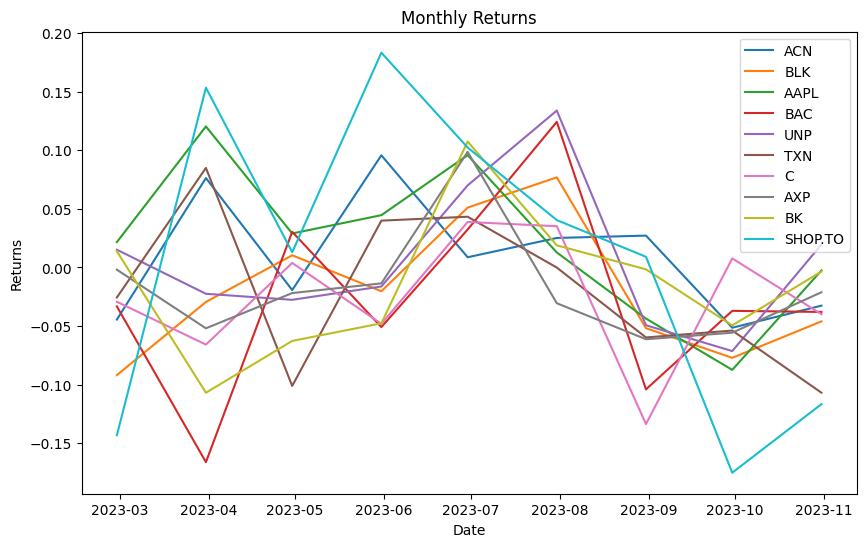

In [18]:
start = '2023-01-01'
end= '2023-11-01'

stocks_data = {ticker: yf.Ticker(ticker).history(start=start, end=end, interval='1mo')['Close'] for ticker in stock_tickers}
market_data = yf.Ticker(market_ticker).history(start=start, end=end, interval='1mo')['Close']

stocks_returns = {ticker: data.resample('M').ffill().pct_change() for ticker, data in stocks_data.items()}
market_returns = market_data.resample('M').ffill().pct_change()

plt.figure(figsize=(10, 6))
for stock in stock_tickers:
    plt.plot(stocks_returns[stock].index, stocks_returns[stock], label=stock)

#plt.plot(market_returns.index, market_returns, color='black', linestyle='-')
plt.title('Monthly Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()

### Phase 3: Determine Optimal Weightings

By selecting the ten riskiest stocks with high correlations, we optimize our portfolio by 'putting all of our eggs into one basket', so to speak. Given that we must abide by the imposed restrictions, we see that the stocks must individually compose 5 to 20% of the portfolio - no stock can compose more than 20% of the portfolio by weight, and no stock can compose less than (100/2n)%, where n is the number of stocks (5% in this case).

The maximize_gain and minimize_gain functions are both optimization functions that allocate the initial budget to a set of stocks with the aim to calculate the optimal weights of each stock to either maximize or minimize the potential gains; all while keeping within the constraints. Two different scenarios of allocations are then calculated for each of these functions, and the total value of the allocated shares is calculated for both the minimize and maximize cases. After this, this total allocation is subtracted for both scenarios from the initial budget of $750,000 that we began with, and the absolute value is taken to measure the value in both scenarios. Either the strategy from maximizing or minimizing gains, whichever one is higher, is chosen. By choosing between maximizing and minimizing gains, we are able to adapt to different market conditions. 

In [19]:
def minimize_gain(initial_budget, current_prices, future_prices):
    n = len(current_prices)

    #calculate expected returns (negative to minimize gain)
    returns = []
    for i in range(n):
        returns.append(-(future_prices[i] - current_prices[i]) / current_prices[i])

    #initialize variables
    weights = [0.0] * n
    remaining_budget = initial_budget

    #sort stocks by expected return in ascending order
    sorted_indices = sorted(range(n), key=returns.__getitem__)

    #distribute budget based on expected returns
    for i in sorted_indices:
        max_weight = min(0.2, (remaining_budget - 4.95) / current_prices[i])
        min_weight = max((100 / (2 * n)) / 100, 0.0001)  #small positive number to avoid division by zero

        #calculate the weight within the allowed range
        weight = min(max_weight, max(min_weight, -returns[i]))

        #update weights and remaining budget
        weights[i] = weight
        remaining_budget -= weight * current_prices[i]  - 4.95

    #distribute any remaining budget equally among the stocks
    if remaining_budget > 0:
        equal_weight = remaining_budget / n
        for i in range(n):
            weights[i] += equal_weight

    #calculate the number of shares to buy for each stock
    shares_allocation = []
    for i in range(n):
        current_price = current_prices[i]
        shares = (weights[i] / sum(weights) * initial_budget / current_price)
        shares_allocation.append(shares)

    return shares_allocation

In [20]:
def maximize_gain(initial_budget, current_prices, future_prices):
    n = len(current_prices)

    #calculate expected returns
    returns = []
    for i in range(n):
        returns.append((future_prices[i] - current_prices[i]) / current_prices[i])

    #initialize variables
    weights = [0.0] * n
    remaining_budget = initial_budget

    #sort stocks by expected return in descending order
    sorted_indices = sorted(range(n), key=returns.__getitem__, reverse=True)

    #distribute budget based on expected returns
    for i in sorted_indices:
        max_weight = min(0.2, (remaining_budget - 4.95) / current_prices[i])
        min_weight = max((100 / (2 * n)) / 100, 0.0001)  #small positive number to avoid division by zero

        #calculate the weight within the allowed range
        weight = min(max_weight, max(min_weight, returns[i]))

        #update weights and remaining budget
        weights[i] = weight
        remaining_budget -= weight * current_prices[i] - 4.95

    #calculate the number of shares to buy for each stock
    shares_allocation = []
    for i in range(n):
        current_price = current_prices[i]
        shares = weights[i] * initial_budget / current_price
        shares_allocation.append(shares)

    return shares_allocation

In [21]:
def compare_gain_allocations(initial_budget, current_prices, future_prices):
    #calculate allocations for both scenarios
    minimize_allocation = minimize_gain(initial_budget, current_prices, future_prices)
    maximize_allocation = maximize_gain(initial_budget, current_prices, future_prices)
    #calculate the total values of the allocated shares
    minimize_total_value = (np.dot(minimize_allocation, future_prices)).sum()
    maximize_total_value = (np.dot(minimize_allocation, future_prices)).sum()

    #calculate absolute differences from 750k
    minimize_difference = abs(initial_budget - minimize_total_value)
    maximize_difference = abs(initial_budget - maximize_total_value)

    #return the df of the one with the greater absolute difference
    if minimize_difference > maximize_difference:
        return minimize_allocation
    else:
        return maximize_allocation

In [22]:
def simulate_next_week(stock_ticker):
    stock_returns = get_close_prices(stock_ticker, start_date, end_date).pct_change().dropna()
    mean_returns = stock_returns.mean()
    std_returns = stock_returns.std()

    #future returns normal distribution
    next_week_returns = np.random.normal(mean_returns, std_returns, days)
    next_week_prices = get_close_prices(stock_ticker, start_date, end_date).iloc[-1] * (1 + next_week_returns.sum())
    #next_week_returns = np.random.normal(0, calc_volatility(stock_ticker), days)
    #next_week_prices = get_close_prices(stock_ticker).iloc[-1] * (1 + next_week_returns.sum())

    return next_week_prices

In [23]:
def multiply_columns_by_ratio(df):
    ratio_value = 100/df.iloc[:, 5].sum()

    for i in range(len(df)):
        df.iloc[i,3] *= ratio_value
        df.iloc[i,4] *= ratio_value
        df.iloc[i,5] *= ratio_value

    return df

In [27]:
# Create an empty DataFrame to store the simulation results of future prices
future_prices = []
current_prices = []
# Iterate through each stock ticker and simulate results for future
for ticker in chosen_stocks:
    next_week_price = simulate_next_week(ticker)
    future_prices.append(next_week_price)

for ticker in chosen_stocks:
    # Append the data to the DataFrame
    stock_ticker = yf.Ticker(ticker)
    currency = stock_ticker.fast_info['currency']
    USDCAD_exchange_ticker = yf.Ticker('USDCAD=x')

    if currency == 'USD':
        # If denominated in USD, convert to CAD using the exchange rate
        close_price = stock_ticker.fast_info['lastPrice'] * USDCAD_exchange_ticker.fast_info['lastPrice']
    else:
        close_price = stock_ticker.fast_info['lastPrice']
    current_prices.append(close_price)

optimal_allocation = compare_gain_allocations(init_investment, current_prices, future_prices)

We normalize the function to ensure that the total weight adds up to 100% and that the total portfolio value adds up to 750k.

### Phase 4: Create Final Portfolio to CSV

In [28]:
def create_final_portfolio(chosen_stocks, allocations):
    #allocations is a list of percentage of each corresponding stock weighting
    #chosen_stocks is list names of chosen stock
    final_portfolio = {'Ticker': [], 'Price': [], 'Currency': [], 'Shares': [], 'Value': [], 'Weight': []}
    total_value = 0
    total_weight = 0
    USDCAD_exchange_ticker = yf.Ticker('USDCAD=x')
    for ticker, allocation in zip(chosen_stocks, allocations):
        stock_info = yf.Ticker(ticker).fast_info
        price = stock_info['lastPrice']
        currency = stock_info['currency']
        if currency == 'USD':
            price = stock_info['lastPrice'] * USDCAD_exchange_ticker.fast_info['lastPrice']
        else:
            price = stock_info['lastPrice']
        value = allocation * price
        weight = (value / 750000) * 100
        total_value += value
        total_weight += weight
        final_portfolio['Ticker'].append(ticker)
        final_portfolio['Price'].append(price)
        final_portfolio['Currency'].append(currency)
        final_portfolio['Shares'].append(allocation)
        final_portfolio['Value'].append(value)
        final_portfolio['Weight'].append(weight)
     # Add total row
    final_portfolio['Ticker'].append('Total')
    final_portfolio['Price'].append('')
    final_portfolio['Currency'].append('')
    final_portfolio['Shares'].append('')
    final_portfolio['Value'].append(total_value)
    final_portfolio['Weight'].append(total_weight)
    portfolio_df = pd.DataFrame(final_portfolio)
    portfolio_df.index = range(1, len(portfolio_df) + 1)
    return portfolio_df

In [37]:
final_portfolio = create_final_portfolio(chosen_stocks, optimal_allocation)
final_portfolio = final_portfolio.drop(final_portfolio.index[-1])
df_modified = multiply_columns_by_ratio(final_portfolio)

total_value = df_modified['Value'].sum()
total_weight = df_modified['Weight'].sum()
print(f'The total value of portfolio: {total_value}')
print(f'The total weight of portfolio: {total_weight}')
df_modified

The total value of portfolio: 750000.0
The total weight of portfolio: 100.0


,Ticker,Price,Currency,Shares,Value,Weight
1,ACN,455.463551,USD,164.667403,75000.0,10.0
2,BLK,995.491316,USD,75.339683,75000.0,10.0
3,AAPL,259.024096,USD,289.548351,75000.0,10.0
4,BAC,40.536854,USD,1850.168229,75000.0,10.0
5,UNP,305.805778,USD,245.253705,75000.0,10.0
6,TXN,209.41996,USD,358.132052,75000.0,10.0
7,C,61.671104,USD,1216.128701,75000.0,10.0
8,AXP,224.186667,USD,334.542642,75000.0,10.0
9,BK,64.561723,USD,1161.679036,75000.0,10.0
10,SHOP.TO,96.260002,CAD,779.139812,75000.0,10.0


Here are our chosen stocks!

Convert portfolio dataframe into a CSV file

In [ ]:
final_csv = df_modified[['Ticker', 'Shares']]
file_name = f"Stocks_Group_02.csv"
final_csv.to_csv(file_name)